In [1]:
import tensorflow as tf
from tensorflow import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
y_t=df.loc[:,'label']
x_t=df.drop(['label'],axis=1)
x_t.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_test=pd.read_csv('test.csv')
print(df_test.shape)

(28000, 784)


In [5]:
x_test=df_test.values.reshape((28000,28,28,1),)
print(x_test.shape)

(28000, 28, 28, 1)


(42000,)
(42000, 784)
AFTER RESHAPHING
(42000, 28, 28, 1)


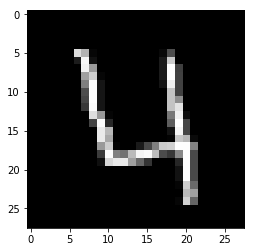

In [6]:
xt=x_t.values
y_train=y_t.values
print(y_train.shape)
print(xt.shape)
print("AFTER RESHAPHING")
x_train=xt.reshape((42000,28,28,1),)
print(x_train.shape)
# print(x_train[7,:,:,:].shape)
plt.imshow(x_train[3,:,:,:].reshape(28,28),cmap='gray')

In [7]:
xyz='conv_test_file.txt'

In [8]:
batch_size =100
learning_rate=0.001
no_epochs=15
m=x_t.shape[0]
m

42000

In [9]:
tf.reset_default_graph() 
# with tf.device('/gpu:0'):
x = tf.placeholder(tf.float32, shape=[None,28,28,1]) 
y = tf.placeholder(tf.int32, shape=[None,])

y_onehot=tf.one_hot(y,10)

tf.set_random_seed(1)
with tf.device('/cpu:0'):
    #Conv Layer1
    W1 = tf.get_variable('W1',shape=[5,5,1,6],initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    # b1 = tf.Variable(tf.zeros([100]))

    l1=tf.nn.relu(tf.nn.conv2d(x,W1,strides=[1,1,1,1],padding='SAME',name='l1'))
    l1_norm=tf.layers.batch_normalization(l1)
    #Conv Layer2
    W2 = tf.get_variable('W2',shape=[4,4,6,12],initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    # b2 = tf.Variable(tf.zeros([10]))

    l2 = tf.nn.relu(tf.nn.conv2d(l1,W2,strides=[1,2,2,1],padding='SAME',name='l2'))
    l2_norm=tf.layers.batch_normalization(l2)

    #Conv Layer3
    W3 = tf.get_variable('W3',shape=[3,3,12,24],initializer=tf.contrib.layers.xavier_initializer(seed = 0))

    l3 = tf.nn.relu(tf.nn.conv2d(l2_norm,W3,strides=[1,2,2,1],padding='SAME',name='l3'))
    l3_norm=tf.layers.batch_normalization(l3)
    # FC LAYER1
    # W4 = tf.Variable(tf.random_normal([588,200]))

    l3_flatten=tf.contrib.layers.flatten(l3_norm)

l4 = tf.contrib.layers.fully_connected(l3_flatten,200)

# l4_dropout=tf.nn.dropout(l4,0.5)

l5 = tf.contrib.layers.fully_connected(l4,10,activation_fn=None) #Activation Function is not applied to get logits


a=tf.nn.softmax(l5)
saver = tf.train.Saver()
with tf.device('/cpu:0'):
    predict=tf.arg_max(a,1)
    
cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=l5, labels=y_onehot) )
acc=tf.reduce_mean(tf.reduce_sum(y_onehot*a,axis=1))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


Instructions for updating:
Use `argmax` instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [10]:
costs=[]
epochs=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(1,no_epochs+1):
        no_of_batches=int(m/batch_size)
        for i in range(no_of_batches):
            batch_x=x_train[i*batch_size:(i+1)*batch_size,:]
#             sess.run(y_t)
            batch_y=y_train[i*batch_size:(i+1)*batch_size]
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        epochs.append(epoch)
        print("Epoch: "+str(epoch))
        costs.append(sess.run(cost,feed_dict={x:x_train, y:y_train}))
        print("Cost: "+str(costs[epoch-1]))
        print("Train Accuracy: "+str(sess.run([acc],feed_dict={x:x_train, y:y_train})))
            
    np.savetxt(xyz,sess.run(predict,feed_dict={x:x_test}),fmt='%d')
    save_path = saver.save(sess, "/tmp/model.ckpt")

Epoch: 1
Cost: 0.08164233
Train Accuracy: [0.9585437]
Epoch: 2
Cost: 0.035902403
Train Accuracy: [0.97999376]
Epoch: 3
Cost: 0.03205387
Train Accuracy: [0.98422045]
Epoch: 4
Cost: 0.019606102
Train Accuracy: [0.9908569]
Epoch: 5
Cost: 0.017353728
Train Accuracy: [0.99150133]
Epoch: 6
Cost: 0.03204603
Train Accuracy: [0.9865537]
Epoch: 7
Cost: 0.013306842
Train Accuracy: [0.9942615]
Epoch: 8
Cost: 0.018916
Train Accuracy: [0.991628]
Epoch: 9
Cost: 0.013531792
Train Accuracy: [0.9939811]
Epoch: 10
Cost: 0.024131503
Train Accuracy: [0.99143845]
Epoch: 11
Cost: 0.01885294
Train Accuracy: [0.99181473]
Epoch: 12
Cost: 0.011045223
Train Accuracy: [0.99488765]
Epoch: 13
Cost: 0.010961606
Train Accuracy: [0.9946883]
Epoch: 14
Cost: 0.014504918
Train Accuracy: [0.9939514]
Epoch: 15
Cost: 0.004975151
Train Accuracy: [0.99755526]


Text(0,0.5,'Cost')

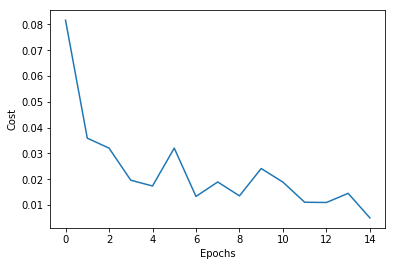

In [11]:
x_val=np.arange(0,len(costs),1,dtype=int)
plt.plot(x_val,costs)
plt.xlabel('Epochs')
plt.ylabel('Cost')

In [12]:
xxx=df_test.loc[55:61].values
print(xxx.shape)
xxx1=np.reshape(xxx,(7,28,28,1))
print("After reshaping\n"+str(xxx1.shape))

(7, 784)
After reshaping
(7, 28, 28, 1)


In [13]:
with tf.Session() as sess2:
    saver.restore(sess2, "/tmp/model.ckpt")
#     np.savetxt(xyz,sess2.run(predict,feed_dict={x:x_test}),fmt='%d')
    print(sess2.run(predict,feed_dict={x:xxx1}))

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
[2 1 2 2 0 4 1]


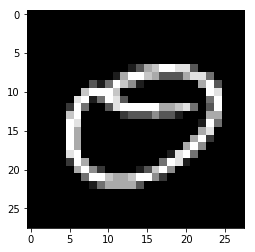

In [14]:
xu=xxx[4,:].reshape((28,28))
plt.imshow(xu,cmap='gray')

In [15]:
df_result=pd.read_csv(xyz,names=['Label'])
df_result.head()
df_result.index+=1
df_result.to_csv('test_label.csv',index=True,index_label='ImageId')